In [1]:
import data_preparation
import matplotlib.pyplot as plt

In [2]:
a, b = data_preparation.get_dataset("div2k")

In [8]:
im = next(a)

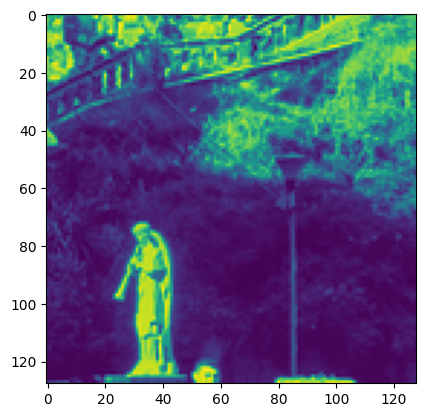

In [9]:
plt.imshow(im[0][0])

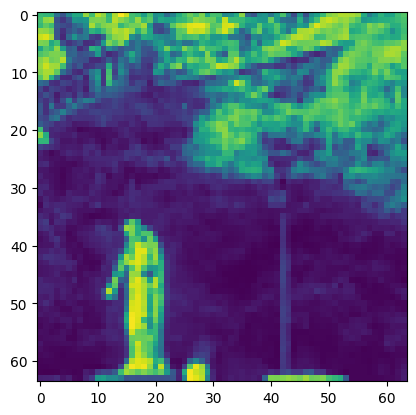

In [10]:
plt.imshow(im[1][0])

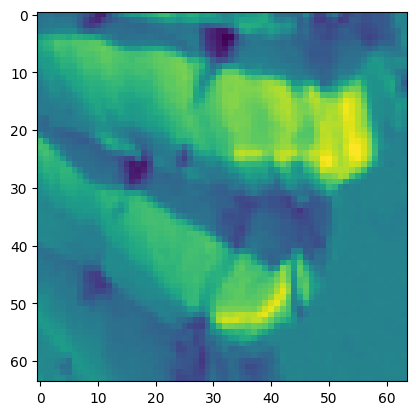

In [3]:
from main import net_fn
import haiku as hk

im = next(a)

network = hk.without_apply_rng(hk.transform(net_fn))
best = None

with open("model.pkl", 'rb') as file:
    import pickle
    best = pickle.load(file)

upscaled = network.apply(best['params'], im.lr)
plt.imshow(im.lr[0])

[[ 51.53273   54.707214  70.70361  ...  78.4628    59.609344  62.492508]
 [ 49.131325  57.70245   71.17364  ...  78.78874   65.58931   63.60906 ]
 [ 68.800644  80.09076   96.20214  ... 109.779785  91.41689   88.57889 ]
 ...
 [ 69.37573   82.149536  99.352196 ... 103.58061   81.84471   79.652084]
 [ 50.347893  63.83165   76.06661  ...  78.41813   68.110435  61.377216]
 [ 43.993343  54.76222   67.140526 ...  73.37686   56.172623  54.685772]]


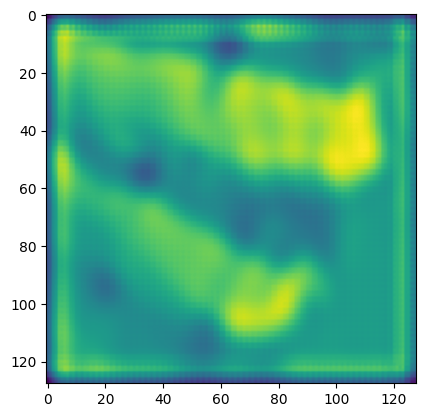

In [4]:
plt.imshow(upscaled[0])

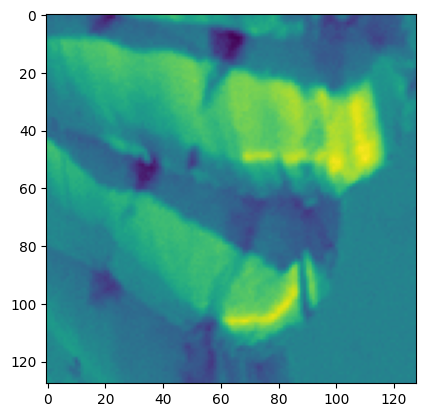

In [5]:
plt.imshow(im.hr[0])